In [158]:
import torchvision.models as models
import torch
from torchvision.datasets import Imagenette
import torchvision.transforms as transforms
import numpy as np
import os
import utils
import foolbox as fb
import time
import matplotlib.pyplot as plt
import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
import foolbox.attacks as fa

In [32]:
net = models.resnet18(weights='DEFAULT').eval()

Orig Label tensor([6])
Actual class name ['garbage truck']
Running attack
Pre tensor([569])
Post tensor([569])


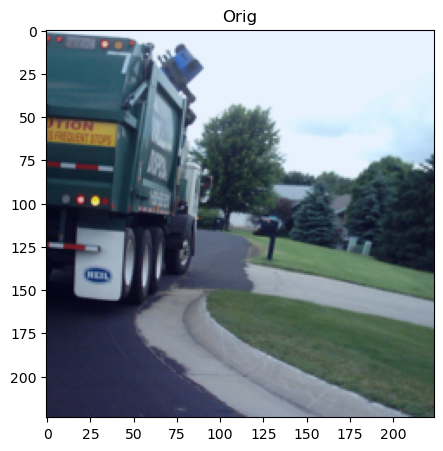

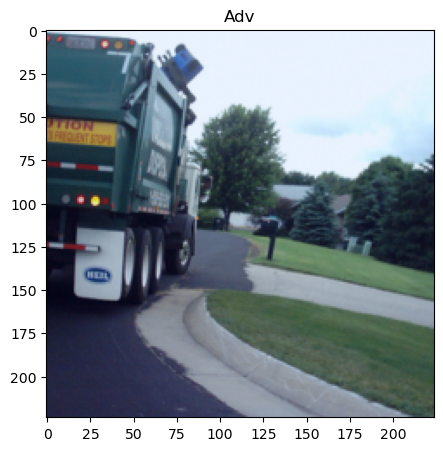

In [71]:
# Switch to evaluation mode

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the root directory and the transforms
root_dir = './data'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)])

# Set the seed for generating random numbers
torch.manual_seed(0)
np.random.seed(0)

# Create an instance of the Imagenette class
try:
    imagenette_train_data = Imagenette(root=root_dir, split='train', transform=transform, download=True)
except:
    imagenette_train_data = Imagenette(root=root_dir, split='train', transform=transform, download=False)

train_loader = data_loader = torch.utils.data.DataLoader(imagenette_train_data, batch_size=1, shuffle=True)
imgs, label = next(iter(train_loader))
print('Orig Label', label)
print('Actual class name', [imagenette_train_data.classes[i][0] for i in label])

# Create an instance of a DeepFool attack
attack = torchattacks.PGD(net, eps=8/225, alpha=2/225, steps=10)
attack.set_normalization_used(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
print('Running attack')
adv_images = attack(imgs, torch.tensor([569]))

# Get the predictions for the adversarial images
labels = open(os.path.join('deepfool_research/synset_words.txt'), 'r').read().split('\n')

pre = utils.get_pred(net, imgs, device='cpu')
post = utils.get_pred(net, adv_images, device='cpu')
print('Pre', pre)
print('Post', post)
utils.imshow(imgs[0], 'Orig')
utils.imshow(adv_images[0], 'Adv')

In [159]:
# instantiate a model (could also be a TensorFlow or JAX model)
model = models.resnet18(pretrained=True).eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)

# get data and test the model
# wrapping the tensors with ep.astensors is optional, but it allows
# us to work with EagerPy tensors in the following
images, labels = ep.astensors(*samples(fmodel, dataset="imagenet", batchsize=16))
clean_acc = accuracy(fmodel, images, labels)
print(f"clean accuracy:  {clean_acc * 100:.1f} %")
print("")

attacks = [
    fa.FGSM(),
    fa.LinfPGD(),
    fa.LinfBasicIterativeAttack(),
    fa.LinfAdditiveUniformNoiseAttack(),
    fa.LinfDeepFoolAttack(),
]

epsilons = [
    0.0,
    0.0005,
    0.001,
    0.0015,
    0.002,
    0.003,
    0.005,
    0.01,
    0.02,
    0.03,
    0.1,
    0.3,
    0.5,
    1.0,
]
print("epsilons")
print(epsilons)
print("")

attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=bool)
for i, attack in enumerate(attacks):
    start = time.time()
    _, _, success = attack(fmodel, images, labels, epsilons=epsilons)
    assert success.shape == (len(epsilons), len(images))
    success_ = success.numpy()
    assert success_.dtype == bool
    attack_success[i] = success_
    print(attack)
    print("  ", 1.0 - success_.mean(axis=-1).round(2))
    print("  ", time.time() - start, "seconds")

# calculate and report the robust accuracy (the accuracy of the model when
# it is attacked) using the best attack per sample
robust_accuracy = 1.0 - attack_success.max(axis=0).mean(axis=-1)
print("")
print("-" * 79)
print("")
print("worst case (best attack per-sample)")
print("  ", robust_accuracy.round(2))
print("")

print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean accuracy:  93.8 %

epsilons
[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0]

LinfFastGradientAttack(rel_stepsize=1.0, abs_stepsize=None, steps=1, random_start=False)
   [0.94 0.81 0.44 0.31 0.25 0.06 0.   0.   0.   0.   0.   0.   0.   0.  ]
   15.658576965332031 seconds
LinfProjectedGradientDescentAttack(rel_stepsize=0.03333333333333333, abs_stepsize=None, steps=40, random_start=True)
   [0.94 0.81 0.38 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   498.07744216918945 seconds
LinfBasicIterativeAttack(rel_stepsize=0.2, abs_stepsize=None, steps=10, random_start=False)
   [0.94 0.69 0.38 0.12 0.06 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
   137.16172099113464 seconds
LinfAdditiveUniformNoiseAttack()
   [0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.94 0.81 0.44 0.12 0.  ]
   4.263609886169434 seconds
LinfDeepFoolAttack(steps=50, candidates=10, overshoot=0.02, loss=logits)
   [0.94 0.75 0.31 0.12 0.06 0.   0.   0.   0.   0.   

In [199]:
# Do a deepfool attack
attack = fa.FGSM()
epsilons = [
    0.0,
    0.0005,
    0.001,
    0.0015,
    0.002,
    0.003,
    0.005,
    0.01,
    0.02,
    0.03,
    0.1,
    0.3,
    0.5,
    1.0,
]
raw_advs, clipped_advs, success = attack(fmodel, images, labels, epsilons=epsilons)

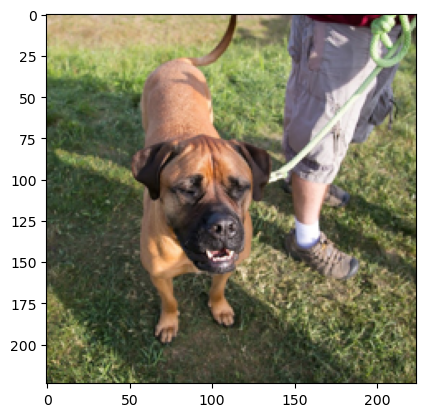

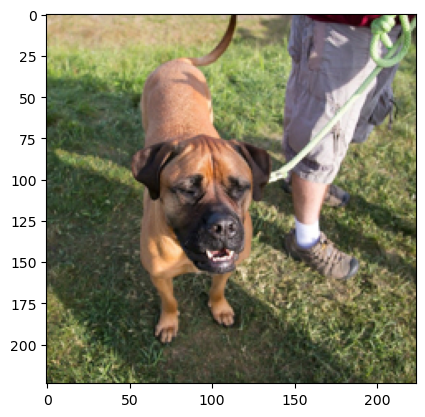

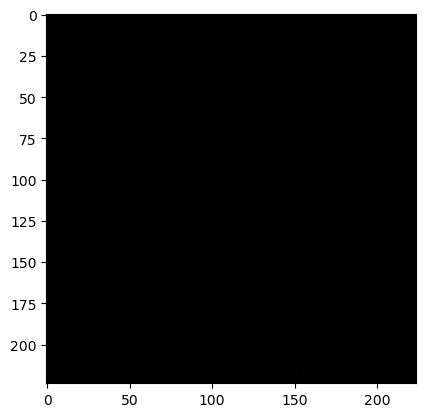

In [213]:
eps_index = 6
# show the perturbed images
plt.imshow(images[0].numpy().transpose(1, 2, 0))
plt.show()
plt.imshow(clipped_advs[eps_index][0].numpy().transpose(1, 2, 0))
plt.show()

# show the difference between the original image and the perturbed image
plt.imshow((clipped_advs[eps_index][0] - images[0]).numpy().transpose(1, 2, 0))